# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
X_train = np.load('data/x_train.npy')
y_train = np.load('data/y_train.npy')

X_test = np.load('data/x_test.npy')
y_test = np.load('data/y_test.npy')

X_val = np.load('data/x_val.npy')
y_val = np.load('data/y_val.npy')

# DT Feature Selection

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score
import time

In [6]:
start_time = time.time()

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

print(f"Seconds: {time.time() - start_time}")

Seconds: 17.202234983444214


In [7]:
feature_importances = clf.feature_importances_
feature_importances = np.array(feature_importances)

feature_importances

array([4.25649439e-04, 2.27843747e-01, 5.67413500e-02, 6.01118228e-03,
       4.83521855e-03, 1.84897351e-02, 0.00000000e+00, 1.62580684e-02,
       1.94414533e-03, 1.00301575e-02, 1.15674132e-01, 1.05869682e-02,
       0.00000000e+00, 0.00000000e+00, 1.37696206e-02, 1.90166277e-02,
       3.01795020e-05, 5.64468352e-03, 3.68200803e-02, 1.22150200e-02,
       1.14292778e-03, 5.27178771e-03, 4.29308892e-03, 4.25429407e-04,
       2.16374501e-02, 3.65831527e-04, 1.16651471e-02, 1.73052354e-03,
       2.06840978e-02, 1.08066153e-03, 4.66241520e-03, 1.15952394e-03,
       3.86447118e-04, 5.47284838e-04, 1.09945242e-03, 5.23449920e-04,
       5.66000588e-04, 1.74863835e-03, 5.48326183e-04, 3.05622869e-04,
       3.60064823e-03, 5.41276029e-03, 1.20572715e-03, 6.35955422e-04,
       9.79870090e-03, 6.59661812e-04, 9.39793782e-03, 8.33772252e-03,
       2.19886657e-01, 7.66271495e-04, 1.39418605e-05, 9.75958288e-03,
       4.35042735e-02, 1.00931593e-04, 3.21843840e-04, 1.71627707e-04,
      

In [8]:
threshold = 0.001
selected_indices = np.where(feature_importances > threshold)[0]
print(f"Number of features selected: {len(selected_indices)}")

Number of features selected: 37


In [9]:
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]
X_val_selected = X_val[:, selected_indices]

In [10]:
y_train = np.where(y_train == 11, 0, 1)
y_test = np.where(y_test == 11, 0, 1)
y_val = np.where(y_val == 11, 0, 1)

## Short Test

In [11]:
clf_selected = DecisionTreeClassifier(random_state=42)
clf_selected.fit(X_train_selected, y_train)

y_pred = clf_selected.predict(X_test_selected)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1 Score with selected features: {f1_macro}")

Macro F1 Score with selected features: 0.994433347474842


# PyDeepInsight

In [12]:
from pyDeepInsight import ImageTransformer

In [13]:
it = ImageTransformer(
    pixels=8,
    feature_extractor='tsne',
    discretization='lsa'
)

In [14]:
it.fit(X_train_selected)
X_train_images = it.transform(X_train_selected, 'pytorch')

X_test_images = it.transform(X_test_selected, 'pytorch')

X_val_images = it.transform(X_val_selected, 'pytorch')

In [15]:
def view_pytorch_images_grid(images, indices=None, rows=1, cols=5):

    if indices is None:
        num_images = min(rows * cols, len(images))
        indices = range(num_images)
    else:
        num_images = len(indices)
        rows = (num_images + cols - 1) // cols 

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        image = images[idx]
        channels = image.shape[0]

        if channels == 1:
            image_to_show = image[0]
            ax.imshow(image_to_show, cmap='gray')
        else:
            image_to_show = np.transpose(image, (1, 2, 0))
            ax.imshow(image_to_show)

        ax.set_title(f'Index {idx}')
        ax.axis('off')

    for ax in axes[len(indices):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


## Visuals

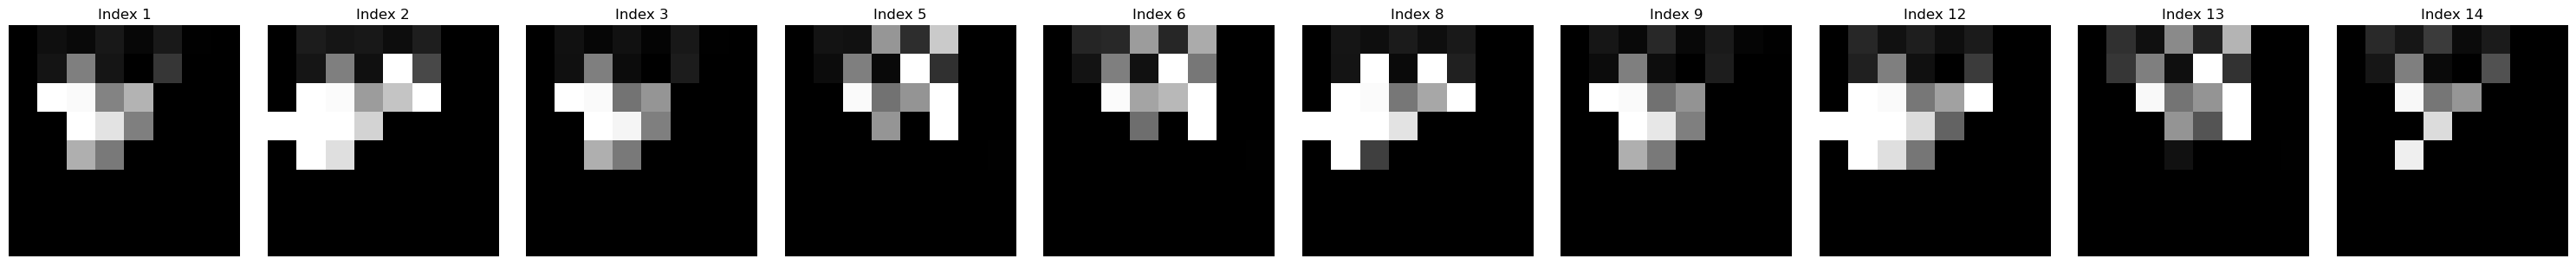

In [16]:
view_pytorch_images_grid(X_train_images, indices=np.where(y_train == 1)[0][:10], rows=1, cols=10)
# Anomaly

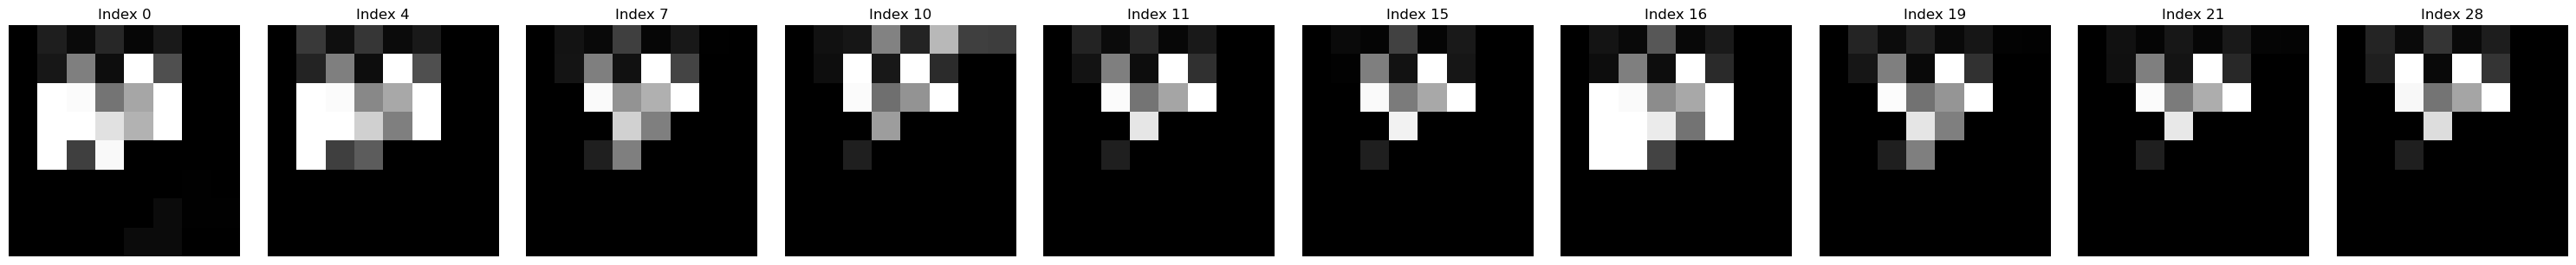

In [17]:
view_pytorch_images_grid(X_train_images, indices=np.where(y_train == 0)[0][:10], rows=1, cols=10)
# Normal

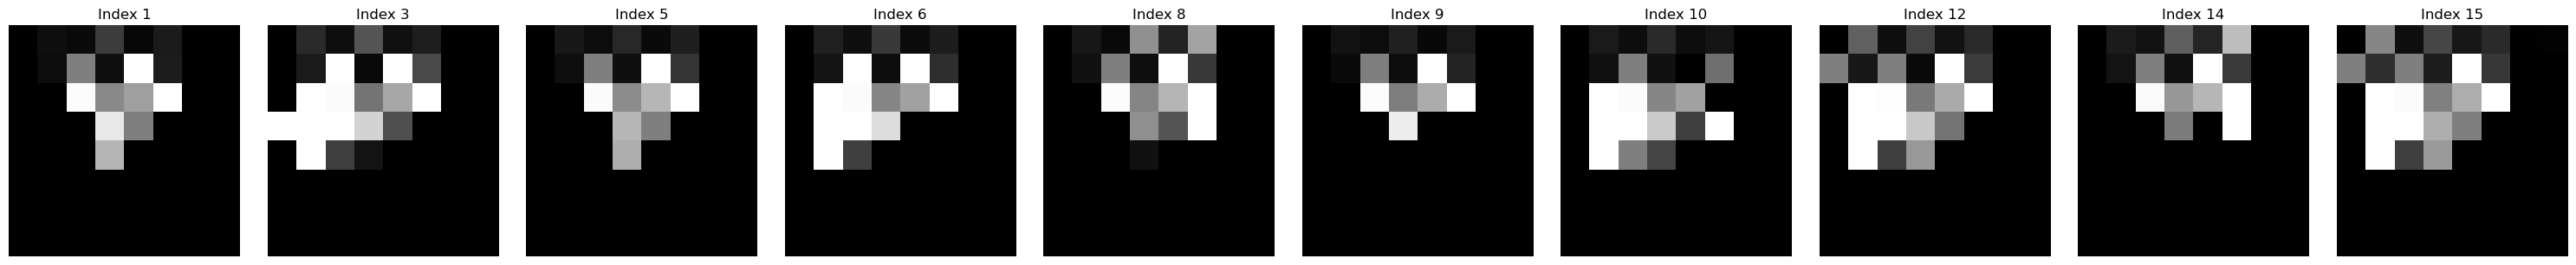

In [18]:
view_pytorch_images_grid(X_test_images, indices=np.where(y_test == 1)[0][:10], rows=1, cols=10)
# Anomaly

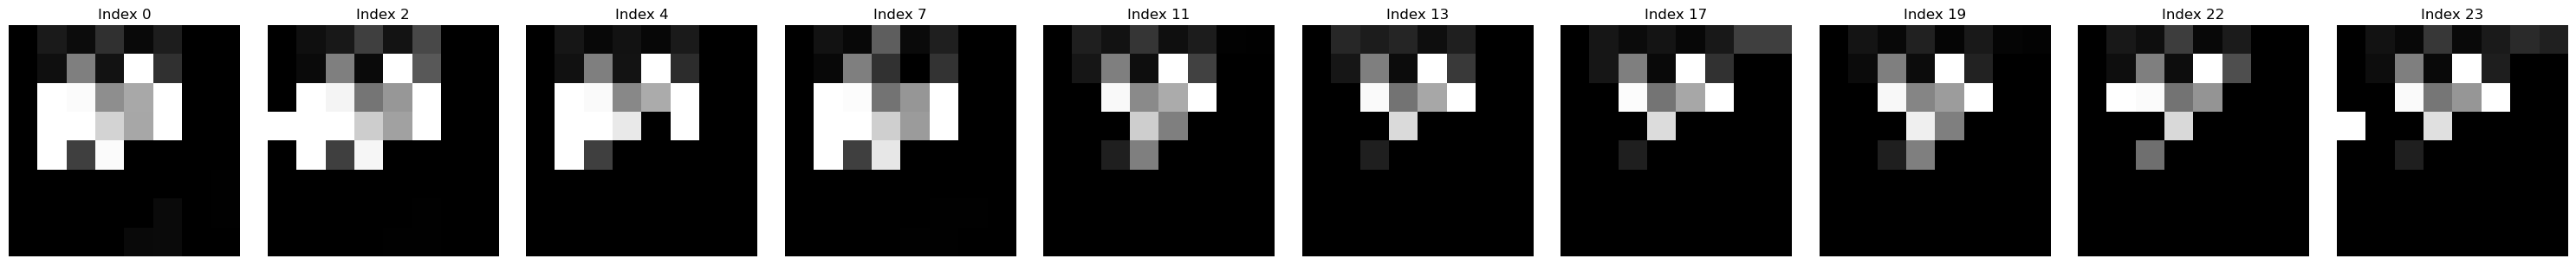

In [19]:
view_pytorch_images_grid(X_test_images, indices=np.where(y_test == 0)[0][:10], rows=1, cols=10)
# Normal

In [20]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([259964, 188771]))

# VAE Model

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [22]:
num_samples, channels, img_height, img_width = X_train_images.shape
latent_dim = 16

In [23]:
class Encoder(nn.Module):
    def __init__(self, img_channels=1, feature_dim=32, latent_dim=2):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(32 * 2 * 2, feature_dim)
        self.fc_mu = nn.Linear(feature_dim, latent_dim)
        self.fc_logvar = nn.Linear(feature_dim, latent_dim)

    def forward(self, x):
        x = self.relu(self.conv1(x))  # Output: (batch_size, 16, 8, 8)
        x = self.pool(x)              # Output: (batch_size, 16, 4, 4)
        x = self.relu(self.conv2(x))  # Output: (batch_size, 32, 4, 4)
        x = self.pool(x)              # Output: (batch_size, 32, 2, 2)
        x = x.view(x.size(0), -1)     # Flatten to (batch_size, 128)
        x = self.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [24]:
class Decoder(nn.Module):
    def __init__(self, img_channels=1, feature_dim=32, latent_dim=2):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, feature_dim)
        self.fc2 = nn.Linear(feature_dim, 32 * 2 * 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, img_channels, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, z):
        x = self.relu(self.fc1(z))           # Output: (batch_size, feature_dim)
        x = self.relu(self.fc2(x))           # Output: (batch_size, 128)
        x = x.view(x.size(0), 32, 2, 2)      # Reshape to (batch_size, 32, 2, 2)
        x = self.upsample(x)                 # Upsample to (batch_size, 32, 4, 4)
        x = self.relu(self.deconv1(x))       # Output: (batch_size, 16, 4, 4)
        x = self.upsample(x)                 # Upsample to (batch_size, 16, 8, 8)
        x = self.sigmoid(self.deconv2(x))    # Output: (batch_size, img_channels, 8, 8)
        return x

In [25]:
class VAE(nn.Module):
    def __init__(self, img_channels=1, feature_dim=32, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = Encoder(img_channels, feature_dim, latent_dim)
        self.decoder = Decoder(img_channels, feature_dim, latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

In [26]:
def loss_function(reconstructed, original, mu, logvar):
    reconstruction_loss = F.mse_loss(reconstructed, original, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = reconstruction_loss + kl_loss
    return total_loss, reconstruction_loss, kl_loss

# VAE Training

In [34]:
normal_indices = np.where(y_train == 0)[0]
X_train_normal = X_train_images[normal_indices]
y_train_normal = y_train[normal_indices]

In [35]:
X_train_tensor = torch.tensor(X_train_normal, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_images, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_images, dtype=torch.float32)

/tmp/ipykernel_167/2228886096.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train_normal, dtype=torch.float32)
/tmp/ipykernel_167/2228886096.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test_images, dtype=torch.float32)
/tmp/ipykernel_167/2228886096.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val_images, dtype=torch.float32)


In [36]:
train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.long))
val_dataset = TensorDataset(X_val_tensor, torch.tensor(y_val, dtype=torch.long))

batch_size = 32 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [37]:
print(len(train_loader))
print(len(test_loader))
print(len(val_loader))

8124
4383
3506


In [422]:
model = VAE(img_channels=channels, feature_dim=32, latent_dim=latent_dim).to(device)
img_channels = X_train_tensor.shape[1]

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch}/{num_epochs}', leave=True)
    
    for batch_idx, (data,) in progress_bar:
        data = data.to(device)

        optimizer.zero_grad()
        reconstructed, mu, logvar = model(data)
        loss, recon_loss, kl_loss = loss_function(reconstructed, data, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}')
    
    # Val
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            data = data.to(device)
            reconstructed, mu, logvar = model(data)
            loss, recon_loss, kl_loss = loss_function(reconstructed, data, mu, logvar)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f'Epoch {epoch}, Average Validation Loss: {avg_val_loss:.4f}')

Epoch 1/20: 100%|██████████| 8124/8124 [00:25<00:00, 319.86it/s]


Epoch 1, Average Loss: 2.8133
Epoch 1, Average Validation Loss: 4.3254


Epoch 2/20: 100%|██████████| 8124/8124 [00:27<00:00, 297.90it/s]


Epoch 2, Average Loss: 2.4367
Epoch 2, Average Validation Loss: 4.3826


Epoch 3/20: 100%|██████████| 8124/8124 [00:24<00:00, 330.62it/s]


Epoch 3, Average Loss: 2.4208
Epoch 3, Average Validation Loss: 4.3597


Epoch 4/20: 100%|██████████| 8124/8124 [00:24<00:00, 327.34it/s]


Epoch 4, Average Loss: 2.4076
Epoch 4, Average Validation Loss: 4.3788


Epoch 5/20: 100%|██████████| 8124/8124 [00:26<00:00, 306.89it/s]


Epoch 5, Average Loss: 2.3626
Epoch 5, Average Validation Loss: 4.3262


Epoch 6/20: 100%|██████████| 8124/8124 [00:26<00:00, 304.18it/s]


Epoch 6, Average Loss: 2.3513
Epoch 6, Average Validation Loss: 4.3206


Epoch 7/20: 100%|██████████| 8124/8124 [00:26<00:00, 308.69it/s]


Epoch 7, Average Loss: 2.3494
Epoch 7, Average Validation Loss: 4.2923


Epoch 8/20: 100%|██████████| 8124/8124 [00:25<00:00, 316.66it/s]


Epoch 8, Average Loss: 2.3437
Epoch 8, Average Validation Loss: 4.3172


Epoch 9/20: 100%|██████████| 8124/8124 [00:25<00:00, 317.85it/s]


Epoch 9, Average Loss: 2.3434
Epoch 9, Average Validation Loss: 4.3731


Epoch 10/20: 100%|██████████| 8124/8124 [00:25<00:00, 321.44it/s]


Epoch 10, Average Loss: 2.3418
Epoch 10, Average Validation Loss: 4.3307


Epoch 11/20: 100%|██████████| 8124/8124 [00:25<00:00, 320.87it/s]


Epoch 11, Average Loss: 2.3419
Epoch 11, Average Validation Loss: 4.3229


Epoch 12/20: 100%|██████████| 8124/8124 [00:26<00:00, 301.04it/s]


Epoch 12, Average Loss: 2.3375
Epoch 12, Average Validation Loss: 4.2965


Epoch 13/20: 100%|██████████| 8124/8124 [00:26<00:00, 307.10it/s]


Epoch 13, Average Loss: 2.3386
Epoch 13, Average Validation Loss: 4.3219


Epoch 14/20: 100%|██████████| 8124/8124 [00:25<00:00, 320.18it/s]


Epoch 14, Average Loss: 2.3365
Epoch 14, Average Validation Loss: 4.3048


Epoch 15/20: 100%|██████████| 8124/8124 [00:25<00:00, 317.62it/s]


Epoch 15, Average Loss: 2.3365
Epoch 15, Average Validation Loss: 4.2897


Epoch 16/20: 100%|██████████| 8124/8124 [00:25<00:00, 314.70it/s]


Epoch 16, Average Loss: 2.3371
Epoch 16, Average Validation Loss: 4.2968


Epoch 17/20: 100%|██████████| 8124/8124 [00:25<00:00, 323.66it/s]


Epoch 17, Average Loss: 2.3342
Epoch 17, Average Validation Loss: 4.3051


Epoch 18/20: 100%|██████████| 8124/8124 [00:27<00:00, 298.84it/s]


Epoch 18, Average Loss: 2.3357
Epoch 18, Average Validation Loss: 4.2982


Epoch 19/20: 100%|██████████| 8124/8124 [00:26<00:00, 308.58it/s]


Epoch 19, Average Loss: 2.3292
Epoch 19, Average Validation Loss: 4.3021


Epoch 20/20: 100%|██████████| 8124/8124 [00:25<00:00, 320.91it/s]


Epoch 20, Average Loss: 2.3300
Epoch 20, Average Validation Loss: 4.3042


In [423]:
torch.save(model.state_dict(), "deepinsight_vae_normal.pth")

# VAE Val Visualize

In [27]:
def visualize_reconstruction(vae, data_loader, device, num_images=5):
    vae.eval() 
    with torch.no_grad():
        for batch in data_loader:
            if isinstance(batch, (list, tuple)):
                images = batch[0]
            else:
                images = batch
            images = images.to(device)
            reconstructed, _, _ = vae(images)
            break

    images = images.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        # Original images
        ax = axes[0, i]
        img = images[i]
        img = np.transpose(img, (1, 2, 0))
        if img.shape[2] == 1:
            img = img.squeeze(-1)
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img)
        ax.axis('off')
        if i == 0:
            ax.set_ylabel('Original', fontsize=12)

        # Reconstructed images
        ax = axes[1, i]
        img = reconstructed[i]
        img = np.transpose(img, (1, 2, 0))
        if img.shape[2] == 1:
            img = img.squeeze(-1)
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img)
        ax.axis('off')
        if i == 0:
            ax.set_ylabel('Reconstructed', fontsize=12)

    plt.tight_layout()
    plt.show()

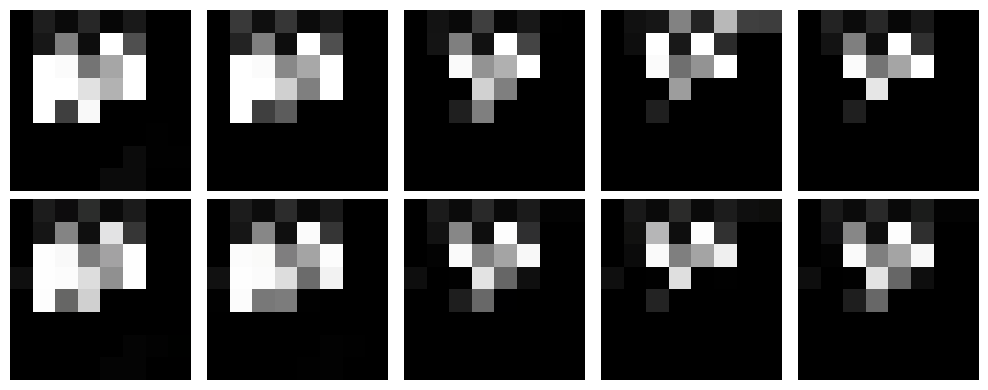

In [425]:
visualize_reconstruction(model, train_loader, device)

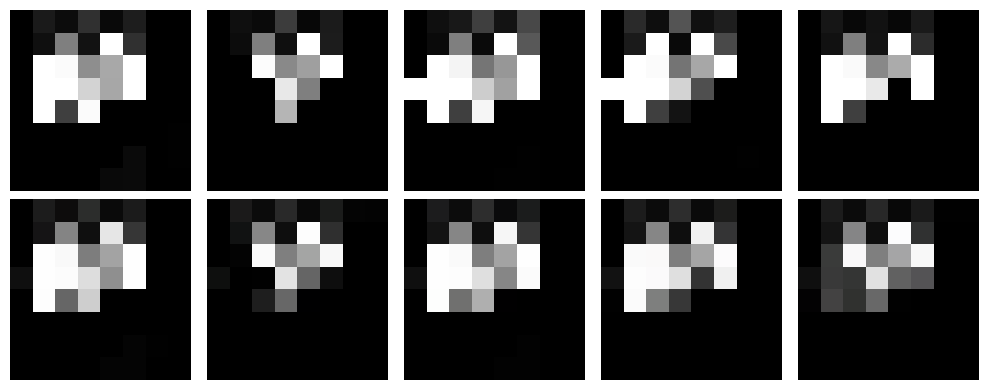

In [426]:
visualize_reconstruction(model, test_loader, device)

# Reconstruction Classification

In [39]:
model = VAE(img_channels=3, feature_dim=32, latent_dim=16).to(device)
model.load_state_dict(torch.load("deepinsight_vae_normal.pth"))

<All keys matched successfully>

In [51]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve
)

In [41]:
def compute_reconstruction_errors(model, data_loader):
    model.eval()
    reconstruction_errors = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            if len(batch) == 1:
                data = batch[0]
                label = None
            elif len(batch) == 2:
                data, label = batch
            else:
                raise ValueError("Unexpected batch size. Expected 1 or 2 elements in batch.")

            data = data.to(device)
            reconstructed, _, _ = model(data)
            # Compute reconstruction error per sample
            loss = F.mse_loss(reconstructed, data, reduction='none')
            loss = loss.view(loss.size(0), -1).mean(dim=1)
            reconstruction_errors.extend(loss.cpu().numpy())

    return np.array(reconstruction_errors)

In [42]:
reconstruction_errors_train = compute_reconstruction_errors(model, train_loader)
reconstruction_errors_val = compute_reconstruction_errors(model, val_loader)
reconstruction_errors_test = compute_reconstruction_errors(model, test_loader)

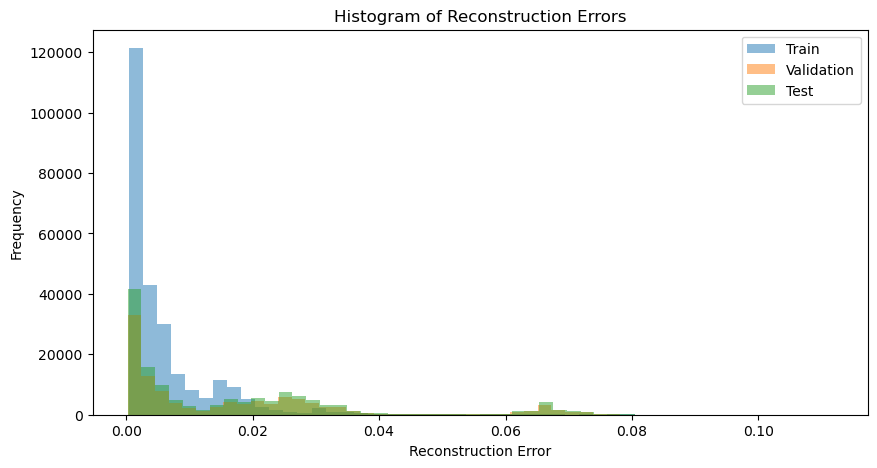

In [43]:
# Plot histograms of reconstruction errors
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors_train, bins=50, alpha=0.5, label='Train')
plt.hist(reconstruction_errors_val, bins=50, alpha=0.5, label='Validation')
plt.hist(reconstruction_errors_test, bins=50, alpha=0.5, label='Test')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Reconstruction Errors')
plt.show()

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_errors_test)
roc_auc = auc(fpr, tpr)

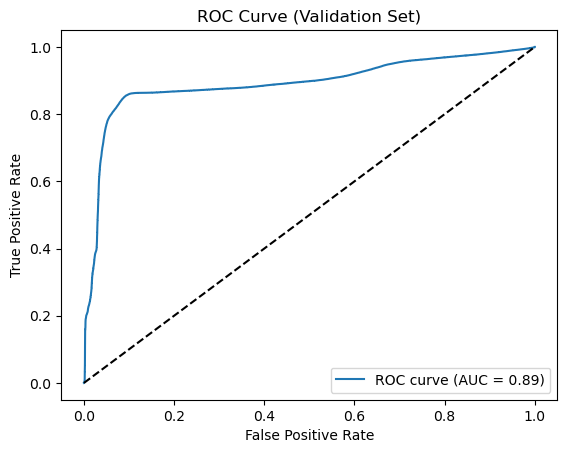

In [49]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Validation Set)')
plt.legend(loc='lower right')
plt.show()

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_errors_test)
roc_auc = auc(fpr, tpr)

f1_scores = []
for threshold in tqdm(thresholds, desc="evaluating thresholds"):
    y_pred = (reconstruction_errors_test >= threshold).astype(int)  # Convert to binary prediction
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold for F1 score: {optimal_threshold}')

evaluating thresholds: 100%|██████████| 26251/26251 [07:15<00:00, 60.33it/s]

Optimal Threshold for F1 score: 0.016530398279428482


In [59]:
y_pred = (reconstruction_errors_test > optimal_threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall_macro = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='binary', zero_division=0)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision (binary): {precision_macro:.4f}')
print(f'Recall (binary): {recall_macro:.4f}')
print(f'F1 Score (binary): {f1_macro:.4f}')

Accuracy: 0.8852
Precision (binary): 0.8850
Recall (binary): 0.8852
F1 Score (binary): 0.8850
